# Importing Libraries #

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

import matplotlib.pyplot as plt
import seaborn as sns

# Loading the Dataset #

In [2]:
tf.keras.utils.get_file(
    fname='cifar-100-python.tar.gz',
    origin='https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz',
    untar=True,
    file_hash='eb9058c3a382ffc7106e4002c42a8d85',
    cache_dir='./Data/',
    cache_subdir='.'
)

print('Dataset Loaded')

Dataset Loaded


Function to unpickle the files

In [3]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

Loading the Dataset and Labels

In [4]:
X_train = unpickle('./Data/cifar-100-python/train')[b'data']
y_train = np.array(unpickle('./Data/cifar-100-python/train')[b'fine_labels'])

X_test = unpickle('./Data/cifar-100-python/test')[b'data']
y_test = np.array(unpickle('./Data/cifar-100-python/test')[b'fine_labels'])

class_names = np.array(unpickle('./Data/cifar-100-python/meta')[b'fine_label_names'])

Reshaping the Data

In [5]:
X_train = np.apply_along_axis(lambda x: x.reshape(3, 32, 32).transpose(1, 2, 0), 1, X_train)

X_test = np.apply_along_axis(lambda x: x.reshape(3, 32, 32).transpose(1, 2, 0), 1, X_test)

Dataset: CIFAR100  
This dataset is just like the CIFAR-10, except it has 100 classes containing 600 images each. There are 500 training images and 100 testing images per class. The 100 classes in the CIFAR-100 are grouped into 20 superclasses. Each image comes with a "fine" label (the class to which it belongs) and a "coarse" label (the superclass to which it belongs)

The Classes are:

|Superclass|Class|
|----------|-----|
|Aquatic Mammals|Beaver, Dolphin, Otter, Seal, Whale|
|Fish|Aquarium Fish, FlatFish, Ray, Shark, Trout|
|Flowers|Orchids, Poppies, Roses, Sunflowers, Tulips|
|Food Containers|Bottles, Bowls, Cans, Cups, Plates|
|Fruit and Vegetables|Apples, Mushrooms, Oranges, Pears, Sweet Peppers|
|Household Electrical Devices|Clock, Computer Keyboard, Lamp, Telephone, Television|
|Household Furniture|Bed, Chair, Couch, Table, Wardrobe|
|Insects|Bee, Beetle, Butterfly, Caterpillar, Cockroach|
|Large Carnivores|Bear, Leopard, Lion, Tiger, Wolf|
|Large Man-Made Outdoor Things|Bridge, Castle, House, Road, Skyscraper|
|Large Natural Outdoor Scenes|Cloud, Forest, Mountain, Plain, Sea|
|Large Omnivores and Herbivores|Camel, Cattle, Chimpanzee, Elephant, Kangaroo|
|Medium-Sized Mammals|Fox, Porcupine, Possum, Raccoon, Skunk|
|Non-Insect Invertebrates|Crab, Lobster, Snail, Spider, Worm|
|People|Baby, Boy, Girl, Man, Woman|
|Reptiles|Crocodile, Dinosaur, Lizard, Snake, Turtle|
|Small Mammals|Hamster, Mouse, Rabbit, Shrew, Squirrel|
|Trees|Maple, Oak, Palm, Pine, Willow|
|Vehicles 1|Bicycle, Bus, Motorcycle, Pickup Truck, Train|
|Vehicles 2|Lawn-Mower, Rocket, Streetcar, Tank, Tractor|

Creating Validation Data  
Validation Data will be last 10000 images from the train set  
The new train set will then be the first 40000 images

In [6]:
X_val = X_train[-10000:]
y_val = y_train[-10000:]

X_train = X_train[:-10000]
y_train = y_train[:-10000]

Class Labels

In [7]:
cifar100_numClasses = len(class_names)

# Data Exploration #

In [8]:
print(f'Shape of X_train: {X_train.shape}')
print(f'Shape of y_train: {y_train.shape}\n')

print(f'Shape of X_val: {X_val.shape}')
print(f'Shape of y_val: {y_val.shape}\n')

print(f'Shape of X_test: {X_test.shape}')
print(f'Shape of y_test: {y_test.shape}\n')

print(f'Shape of class_names: {class_names.shape}')

Shape of X_train: (40000, 32, 32, 3)
Shape of y_train: (40000,)

Shape of X_val: (10000, 32, 32, 3)
Shape of y_val: (10000,)

Shape of X_test: (10000, 32, 32, 3)
Shape of y_test: (10000,)

Shape of class_names: (100,)


Showing first 10 images from the training set before augmentation

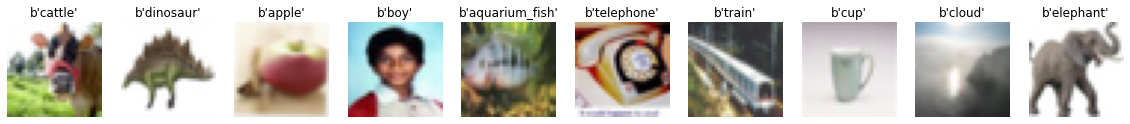

In [9]:
plt.figure(figsize=(20, 20))

for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(X_train[i])
    plt.title(class_names[y_train[i]])
    plt.axis('off')
    
plt.show()

Applying Uniform Manifold Approximation & Projection

In [12]:
import umap

reducer = umap.UMAP()
embedding = reducer.fit_transform(X_train.reshape(X_train.shape[0], X_train.shape[1] * X_train.shape[2] * X_train.shape[3]))
print(f'Shape of embedded images: {embedding.shape}')

Shape of embedded images: (40000, 2)


From the UMAP plot, it can be seen that the dataset is extremely complex and could not be visualised on a 2 dimensional plane

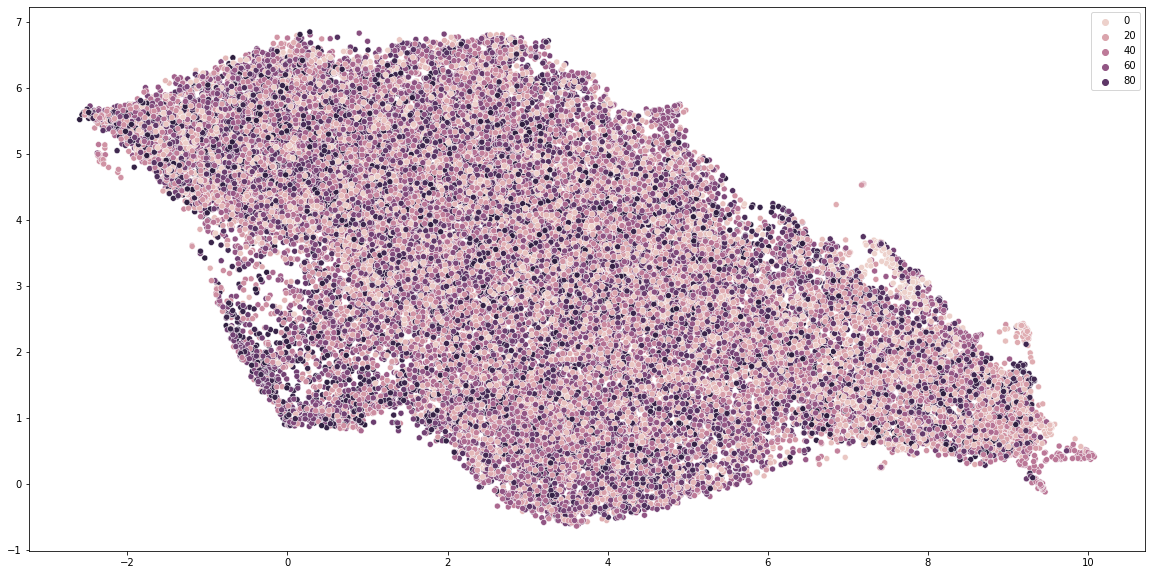

In [13]:
plt.figure(figsize=(20, 10))
sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=y_train)
plt.show()

# Data Augmentation Layers #

In [11]:
import keras_cv

## AugMix ##

Augmix is a data augmentation technique that tries to retain the characteristics of the original data while producing meaningful augmented data

Paper that introduced AugMix: https://arxiv.org/pdf/1912.02781

In [17]:
augMix = keras_cv.layers.AugMix([0, 255], 0.5, 5, [1, 5], seed=42)

X_train_Aug = augMix(X_train)

Showing first 10 images from the training set after AugMix augmentation

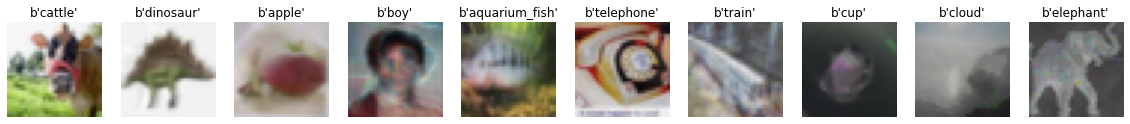

In [18]:
plt.figure(figsize=(20, 20))

for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(X_train_Aug[i] / 255)
    plt.title(class_names[y_train[i]])
    plt.axis('off')
    
plt.show()

Saving the Tensor to a file for future loading

In [20]:
np.save('./Data/AugXTrain.npy', X_train_Aug.numpy())

## Channel Shuffle ##

Channel Shuffle is basically the shuffling of the colour channels in the data

In [12]:
channelShuff = keras_cv.layers.ChannelShuffle(seed=42)

X_train_Chan = channelShuff(X_train)

Showing the first 10 images from the training set after Channel Shuffling augmentation

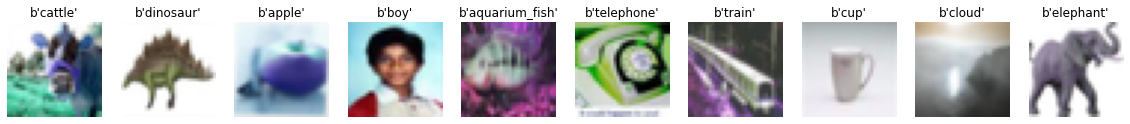

In [13]:
plt.figure(figsize=(20, 20))

for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(X_train_Chan[i] / 255)
    plt.title(class_names[y_train[i]])
    plt.axis('off')
    
plt.show()

In [14]:
np.save('./Data/ChanXTrain.npy', X_train_Chan)

## Grid Mask ##

Grid Mask is adding holes into the images in a grid like pattern

In [15]:
gridMask = keras_cv.layers.GridMask(seed=42)

X_train_Grid = gridMask(X_train)

Showing the first 10 images from the training set after Grid Mask augmentation

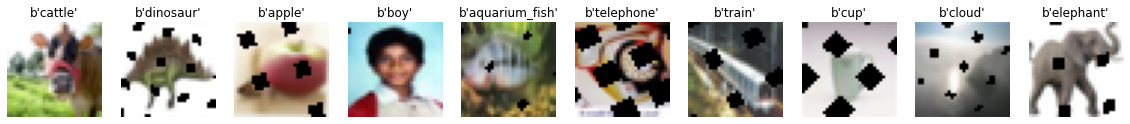

In [16]:
plt.figure(figsize=(20, 20))

for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(X_train_Grid[i] / 255)
    plt.title(class_names[y_train[i]])
    plt.axis('off')
    
plt.show()

In [17]:
np.save('./Data/GridXTrain.npy', X_train_Grid)

# Load the Augmented Train Data #

In [10]:
X_train1 = np.load('./Data/AugXTrain.npy')
X_train2 = np.load('./Data/ChanXTrain.npy')
X_train3 = np.load('./Data/GridXTrain.npy')

Showing 10 images from the training sets

## AugMix ##

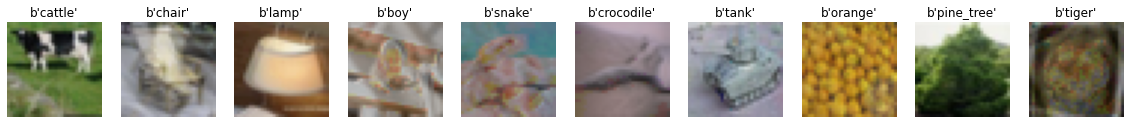

In [11]:
plt.figure(figsize=(20, 20))

for i in range(10):
    index = np.random.randint(0, 39000)
    plt.subplot(1, 10, i + 1)
    plt.imshow(X_train1[index] / 255)
    plt.title(class_names[y_train[index]])
    plt.axis('off')
    
plt.show()

## Channel Shuffle ##

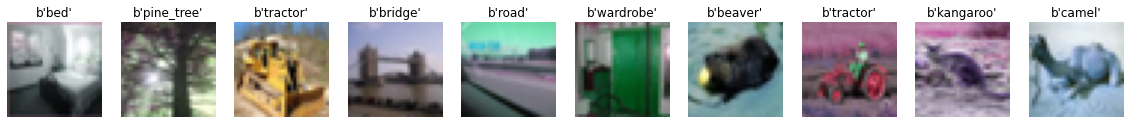

In [12]:
plt.figure(figsize=(20, 20))

for i in range(10):
    index = np.random.randint(0, 39000)
    plt.subplot(1, 10, i + 1)
    plt.imshow(X_train2[index] / 255)
    plt.title(class_names[y_train[index]])
    plt.axis('off')
    
plt.show()

## GridMask ##

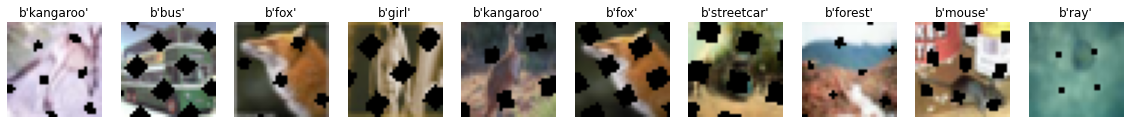

In [13]:
plt.figure(figsize=(20, 20))

for i in range(10):
    index = np.random.randint(0, 39000)
    plt.subplot(1, 10, i + 1)
    plt.imshow(X_train3[index] / 255)
    plt.title(class_names[y_train[index]])
    plt.axis('off')
    
plt.show()

## Combining Train Data ##

In [14]:
X_train = np.concatenate([X_train1, X_train2, X_train3])
y_train = np.concatenate([y_train, y_train, y_train])

In [15]:
print(f'Samples in Training Data: {X_train.shape[0]}')
print(f'Samples in Training Label: {y_train.shape[0]}')

Samples in Training Data: 120000
Samples in Training Label: 120000


# Changing Data to Tensorflow datasets #

In [64]:
trainDS = tf.data.Dataset.from_tensor_slices((X_train, y_train))

valDS = tf.data.Dataset.from_tensor_slices((X_val, y_val))
testDS = tf.data.Dataset.from_tensor_slices((X_test, y_test))

Batching the Validation and Test datasets

In [65]:
BATCH_SIZE=64
SHUFFLE_BUFFER_SIZE = 2000

trainDS = trainDS.shuffle(SHUFFLE_BUFFER_SIZE, seed=42).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
valDS = valDS.batch(BATCH_SIZE)
testDS = testDS.batch(BATCH_SIZE)

# Model Building #

## Model 1 ##
Simple Baseline Model

<img src='Images/Model1_Arch.png' width='300' height='500' style='display:block; margin: auto'/>
<p style='text-align: center'>
    <b>Model 1 Architecture</b>
</p>

In [18]:
input = layers.Input((32, 32, 3))
x = layers.Rescaling(1/255)(input)

x = layers.Conv2D(16, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPool2D()(x)

x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPool2D()(x)

x = layers.Dropout(0.2)(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.BatchNormalization()(x)

output = layers.Dense(cifar100_numClasses, activation='softmax')(x)

model1 = keras.Model(inputs=input, outputs=output, name='Model_1')

In [19]:
model1.summary()

Model: "Model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 rescaling (Rescaling)       (None, 32, 32, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 16)        448       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                         

## Model 2 ##

<img src='Images/Model2_Arch.png' width='300' height='500' style='display:block; margin: auto'/>
<p style='text-align: center'>
    <b>Model 2 Architecture</b>
</p>

In [20]:
input = layers.Input((32, 32, 3))
x = layers.Rescaling(1/255)(input)

x = layers.Conv2D(16, 3, padding='same', activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)

x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPool2D()(x)

x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)

x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPool2D()(x)

x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(256, 3, padding='same')(x)
x = layers.BatchNormalization()(x)

x = layers.Dropout(0.3)(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01))(x)
x = layers.BatchNormalization()(x)

output = layers.Dense(cifar100_numClasses, activation='softmax')(x)

model2 = keras.Model(inputs=input, outputs=output, name='Model_2')

In [21]:
model2.summary()

Model: "Model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 32, 32, 3)         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 16)        448       
                                                                 
 dropout_1 (Dropout)         (None, 32, 32, 16)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 batch_normalization_3 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                           

## Model 3 ##

<img src='Images/Model3_Arch.png' width='300' height='500' style='display:block; margin: auto'/>
<p style='text-align: center'>
    <b>Model 3 Architecture</b>
</p>

In [22]:
input = layers.Input((32, 32, 3))
x = layers.Rescaling(1/255)(input)

x = layers.Conv2D(16, 3, padding='same', activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)

x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPool2D()(x)

x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)

x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPool2D()(x)

x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)

x = layers.Dropout(0.3)(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01))(x)
x = layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01))(x)
x = layers.Dense(64)(x)
x = layers.BatchNormalization()(x)

output = layers.Dense(cifar100_numClasses, activation='softmax')(x)

model3 = keras.Model(inputs=input, outputs=output, name='Model_3')

In [23]:
model3.summary()

Model: "Model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 32, 32, 3)         0         
                                                                 
 conv2d_13 (Conv2D)          (None, 32, 32, 16)        448       
                                                                 
 dropout_6 (Dropout)         (None, 32, 32, 16)        0         
                                                                 
 conv2d_14 (Conv2D)          (None, 32, 32, 32)        4640      
                                                                 
 batch_normalization_9 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                           

# Model Testing #

## Function for plotting accuracy and loss ##

In [4]:
def plotFallOffGraph(history, accuracy='accuracy', val_accuracy='val_accuracy', loss='loss', val_loss='val_loss'):
    acc = history.history[accuracy]
    val_acc = history.history[val_accuracy]

    loss = history.history[loss]
    val_loss = history.history[val_loss]

    epochs_range = range(len(history.epoch))

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

## Learning Rate Decay ##

In [25]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.001,
    decay_steps=1875*100,
    decay_rate=5,
    staircase=False
)

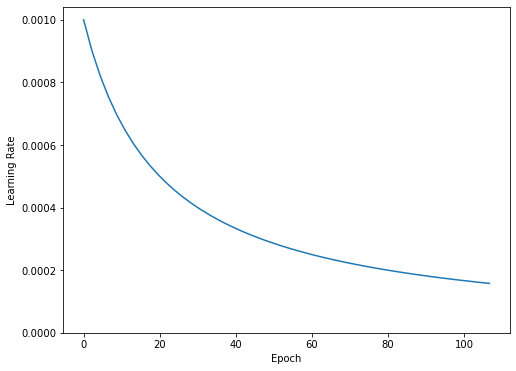

In [26]:
step = np.linspace(0, 200000)
lr = lr_schedule(step)
plt.figure(figsize=(8, 6))
plt.plot(step/1875, lr)
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')

## Model 1 ##

In [27]:
model1.compile(optimizer=keras.optimizers.Adam(lr_schedule), loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [28]:
history1 = model1.fit(trainDS, epochs=25, validation_data=valDS)

Epoch 1/25
1875/1875 [==============================] - 19s 9ms/step - loss: 3.1186 - accuracy: 0.2564 - val_loss: 2.5043 - val_accuracy: 0.3695
Epoch 2/25
1875/1875 [==============================] - 17s 9ms/step - loss: 2.1142 - accuracy: 0.4545 - val_loss: 2.3448 - val_accuracy: 0.4111
Epoch 3/25
1875/1875 [==============================] - 17s 9ms/step - loss: 1.5694 - accuracy: 0.5795 - val_loss: 2.5518 - val_accuracy: 0.3946
Epoch 4/25
1875/1875 [==============================] - 17s 9ms/step - loss: 1.1820 - accuracy: 0.6750 - val_loss: 2.7127 - val_accuracy: 0.4097
Epoch 5/25
1875/1875 [==============================] - 17s 9ms/step - loss: 0.9235 - accuracy: 0.7387 - val_loss: 2.8455 - val_accuracy: 0.4189
Epoch 6/25
1875/1875 [==============================] - 17s 9ms/step - loss: 0.7507 - accuracy: 0.7821 - val_loss: 3.1135 - val_accuracy: 0.4091
Epoch 7/25
1875/1875 [==============================] - 17s 9ms/step - loss: 0.6345 - accuracy: 0.8142 - val_loss: 3.2876 - val_ac

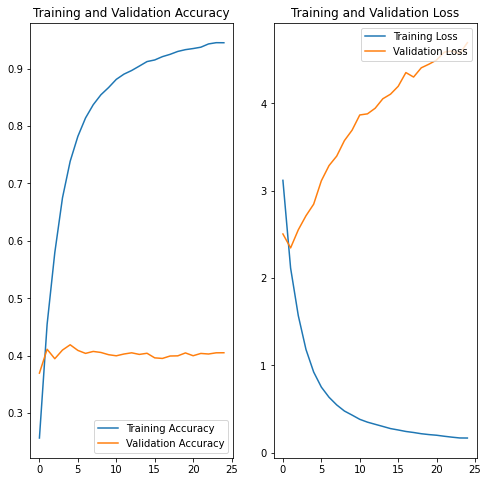

In [29]:
plotFallOffGraph(history1)

In [30]:
print(f'The highest validation accuracy obtained: {max(history1.history["val_accuracy"])}')
print(f'The lowest loss obtained: {min(history1.history["val_loss"])}')

The highest validation accuracy obtained: 0.4189000129699707
The lowest loss obtained: 2.344834327697754


In [31]:
model1.save('./Models/Model1/')

INFO:tensorflow:Assets written to: ./Models/Model1/assets


INFO:tensorflow:Assets written to: ./Models/Model1/assets


In [32]:
tf.keras.backend.clear_session()

## Model 2 ##

In [33]:
model2.compile(optimizer=keras.optimizers.Adam(lr_schedule), loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [34]:
history2 = model2.fit(trainDS, epochs=25, validation_data=valDS)

Epoch 1/25
1875/1875 [==============================] - 64s 33ms/step - loss: 4.2930 - accuracy: 0.1553 - val_loss: 3.7728 - val_accuracy: 0.2247
Epoch 2/25
1875/1875 [==============================] - 63s 33ms/step - loss: 3.5111 - accuracy: 0.2856 - val_loss: 3.5489 - val_accuracy: 0.2890
Epoch 3/25
1875/1875 [==============================] - 63s 33ms/step - loss: 3.1966 - accuracy: 0.3512 - val_loss: 3.2428 - val_accuracy: 0.3452
Epoch 4/25
1875/1875 [==============================] - 63s 33ms/step - loss: 2.9706 - accuracy: 0.3988 - val_loss: 2.9363 - val_accuracy: 0.4124
Epoch 5/25
1875/1875 [==============================] - 63s 34ms/step - loss: 2.7550 - accuracy: 0.4410 - val_loss: 2.7591 - val_accuracy: 0.4453
Epoch 6/25
1875/1875 [==============================] - 63s 33ms/step - loss: 2.5663 - accuracy: 0.4739 - val_loss: 2.7160 - val_accuracy: 0.4456
Epoch 7/25
1875/1875 [==============================] - 63s 33ms/step - loss: 2.3937 - accuracy: 0.5062 - val_loss: 2.4794 -

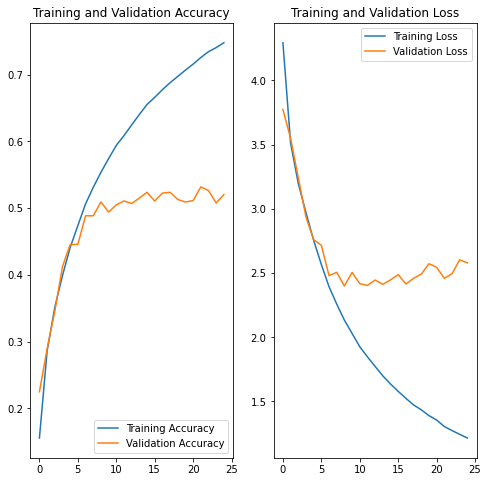

In [35]:
plotFallOffGraph(history2)

In [36]:
print(f'The highest validation accuracy obtained: {max(history2.history["val_accuracy"])}')
print(f'The lowest loss obtained: {min(history2.history["val_loss"])}')

The highest validation accuracy obtained: 0.5317999720573425
The lowest loss obtained: 2.398913621902466


In [37]:
model2.save('./Models/Model2/')

INFO:tensorflow:Assets written to: ./Models/Model2/assets


INFO:tensorflow:Assets written to: ./Models/Model2/assets


In [38]:
tf.keras.backend.clear_session()

## Model 3 ##

In [39]:
model3.compile(optimizer=keras.optimizers.Adam(lr_schedule), loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [40]:
history3 = model3.fit(trainDS, epochs=25, validation_data=valDS)

Epoch 1/25
1875/1875 [==============================] - 101s 53ms/step - loss: 4.5815 - accuracy: 0.0651 - val_loss: 4.1816 - val_accuracy: 0.0861
Epoch 2/25
1875/1875 [==============================] - 100s 53ms/step - loss: 3.9139 - accuracy: 0.1376 - val_loss: 3.6523 - val_accuracy: 0.1686
Epoch 3/25
1875/1875 [==============================] - 100s 53ms/step - loss: 3.5198 - accuracy: 0.1979 - val_loss: 3.5303 - val_accuracy: 0.1912
Epoch 4/25
1875/1875 [==============================] - 100s 53ms/step - loss: 3.2527 - accuracy: 0.2514 - val_loss: 3.3709 - val_accuracy: 0.2273
Epoch 5/25
1875/1875 [==============================] - 100s 53ms/step - loss: 3.0527 - accuracy: 0.2912 - val_loss: 3.1975 - val_accuracy: 0.2668
Epoch 6/25
1875/1875 [==============================] - 100s 53ms/step - loss: 2.8818 - accuracy: 0.3247 - val_loss: 2.9053 - val_accuracy: 0.3190
Epoch 7/25
1875/1875 [==============================] - 100s 53ms/step - loss: 2.7463 - accuracy: 0.3548 - val_loss: 2

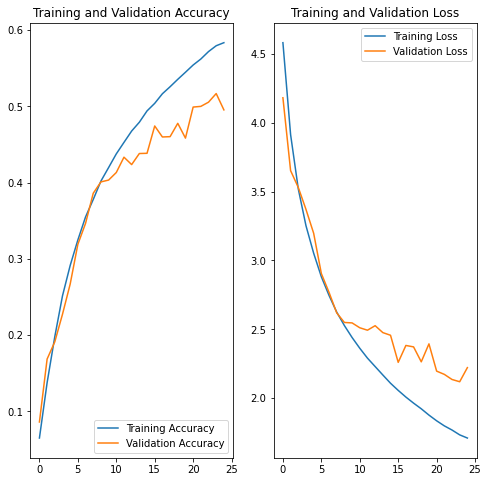

In [41]:
plotFallOffGraph(history3)

In [42]:
print(f'The highest validation accuracy obtained: {max(history3.history["val_accuracy"])}')
print(f'The lowest loss obtained: {min(history3.history["val_loss"])}')

The highest validation accuracy obtained: 0.5166000127792358
The lowest loss obtained: 2.1194262504577637


In [43]:
model3.save('./Models/Model3/')

INFO:tensorflow:Assets written to: ./Models/Model3/assets


INFO:tensorflow:Assets written to: ./Models/Model3/assets


In [44]:
tf.keras.backend.clear_session()

# Candidate Models #
The Models that I will be choosing to be candidate models are Model 2 and Model 3 which will be now called Model A and Model B respectively because for both models their accuracies are decent and also because they contain more parameters compared to Model 1 so these two models will have a higher possibility to not plateau because they have "more room to grow"  
However as a way to make sure the correct model will be chosen as the final model, both candidate models will be hyperparameter tuned

This was done to ensure that both candidate models has a chance to be tested and find out which will perform better on the test set which will contain unseen data and will be the final test to choose the final model to be used

## Models Hyperparameter Training Parameters and imports ##

In [45]:
import keras_tuner as kt

## Building Models for Hyperparameter Tuning ##

In [55]:
def CandidateABuilder(hp):
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 15e-4, 1e-4, 2e-3, 25e-4, 2e-4])
    hp_activation_func = hp.Choice('activation', values=['relu', 'sigmoid', 'tanh', 'swish'])
    hp_dropout_rate = hp.Choice('dropout_rate', values=[0.3, 0.4, 0.5, 0.6])
    
    lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
        hp_learning_rate,
        decay_steps=1875*100,
        decay_rate=5,
        staircase=False
    )
    
    input = layers.Input((32, 32, 3))
    x = layers.Rescaling(1/255)(input)

    x = layers.Conv2D(16, 3, padding='same', activation=hp_activation_func)(x)
    x = layers.Dropout(hp_dropout_rate)(x)
    x = layers.Conv2D(32, 3, padding='same', activation=hp_activation_func)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv2D(64, 3, padding='same', activation=hp_activation_func)(x)
    x = layers.Dropout(hp_dropout_rate)(x)
    x = layers.Conv2D(128, 3, padding='same', activation=hp_activation_func)(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D()(x)

    x = layers.Conv2D(256, 3, padding='same', activation=hp_activation_func)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv2D(128, 3, padding='same', activation=hp_activation_func)(x)
    x = layers.Dropout(hp_dropout_rate)(x)
    x = layers.Conv2D(128, 3, padding='same', activation=hp_activation_func)(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D()(x)

    x = layers.Conv2D(256, 3, padding='same', activation=hp_activation_func)(x)
    x = layers.Dropout(hp_dropout_rate)(x)
    x = layers.Conv2D(256, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Dropout(hp_dropout_rate)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation=hp_activation_func, kernel_regularizer=keras.regularizers.l2(0.01))(x)
    x = layers.BatchNormalization()(x)

    output = layers.Dense(cifar100_numClasses, activation='softmax')(x)

    model = keras.Model(inputs=input, outputs=output, name='Model_A')
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_schedule), loss=keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
    
    return model

In [56]:
def CandidateBBuilder(hp):
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 15e-4, 1e-4, 2e-3, 25e-4, 2e-4])
    hp_activation_func = hp.Choice('activation', values=['relu', 'sigmoid', 'tanh', 'swish'])
    hp_dropout_rate = hp.Choice('dropout_rate', values=[0.3, 0.4, 0.5, 0.6])
    
    lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
        hp_learning_rate,
        decay_steps=1875*100,
        decay_rate=5,
        staircase=False
    )
    
    input = layers.Input((32, 32, 3))
    x = layers.Rescaling(1/255)(input)

    x = layers.Conv2D(16, 3, padding='same', activation=hp_activation_func)(x)
    x = layers.Dropout(hp_dropout_rate)(x)
    x = layers.Conv2D(32, 3, padding='same', activation=hp_activation_func)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv2D(64, 3, padding='same', activation=hp_activation_func)(x)
    x = layers.Dropout(hp_dropout_rate)(x)
    x = layers.Conv2D(128, 3, padding='same', activation=hp_activation_func)(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D()(x)

    x = layers.Conv2D(256, 3, padding='same', activation=hp_activation_func)(x)
    x = layers.Dropout(hp_dropout_rate)(x)
    x = layers.Conv2D(256, 3, padding='same', activation=hp_activation_func)(x)
    x = layers.Dropout(hp_dropout_rate)(x)
    x = layers.Conv2D(256, 3, padding='same', activation=hp_activation_func)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv2D(128, 3, padding='same', activation=hp_activation_func)(x)
    x = layers.Dropout(hp_dropout_rate)(x)
    x = layers.Conv2D(128, 3, padding='same', activation=hp_activation_func)(x)
    x = layers.Dropout(hp_dropout_rate)(x)
    x = layers.Conv2D(128, 3, padding='same', activation=hp_activation_func)(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D()(x)

    x = layers.Conv2D(256, 3, padding='same', activation=hp_activation_func)(x)
    x = layers.Dropout(hp_dropout_rate)(x)
    x = layers.Conv2D(256, 3, padding='same', activation=hp_activation_func)(x)
    x = layers.Dropout(hp_dropout_rate)(x)
    x = layers.Conv2D(256, 3, padding='same', activation=hp_activation_func)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Dropout(hp_dropout_rate)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation=hp_activation_func, kernel_regularizer=keras.regularizers.l2(0.01))(x)
    x = layers.Dense(128, activation=hp_activation_func, kernel_regularizer=keras.regularizers.l2(0.01))(x)
    x = layers.Dense(64)(x)
    x = layers.BatchNormalization()(x)

    output = layers.Dense(cifar100_numClasses, activation='softmax')(x)

    model = keras.Model(inputs=input, outputs=output, name='Model_B')
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_schedule), loss=keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
    
    return model

## Hyperparameter Tuning The Finalised Model ##

The tuning algorithm that I will be using is Hyperband which can be inplemented using KerasTuner
Paper that introduced Hyperband: http://jmlr.org/papers/v18/16-558.html

In [57]:
tunerA = kt.Hyperband(CandidateABuilder, objective='val_accuracy', max_epochs=30, project_name='Hypertuned_ModelA', hyperband_iterations=3, seed=42)

INFO:tensorflow:Reloading Oracle from existing project .\Hypertuned_ModelA\oracle.json


INFO:tensorflow:Reloading Oracle from existing project .\Hypertuned_ModelA\oracle.json


INFO:tensorflow:Reloading Tuner from .\Hypertuned_ModelA\tuner0.json


INFO:tensorflow:Reloading Tuner from .\Hypertuned_ModelA\tuner0.json


In [58]:
tunerB = kt.Hyperband(CandidateBBuilder, objective='val_accuracy', max_epochs=30, project_name='Hypertuned_ModelB', hyperband_iterations=3, seed=42)

INFO:tensorflow:Reloading Oracle from existing project .\Hypertuned_ModelB\oracle.json


INFO:tensorflow:Reloading Oracle from existing project .\Hypertuned_ModelB\oracle.json


INFO:tensorflow:Reloading Tuner from .\Hypertuned_ModelB\tuner0.json


INFO:tensorflow:Reloading Tuner from .\Hypertuned_ModelB\tuner0.json


### Searching for best params ###

In [ ]:
tunerA.search(trainDS, epochs=5, validation_data=valDS)

In [107]:
best_hpsA = tunerA.get_best_hyperparameters(num_trials=1)[0]

print(f'Best learning rate: {best_hpsA.get("learning_rate")}')
print(f'Best activation function: {best_hpsA.get("activation")}')
print(f'Best dropout rate: {best_hpsA.get("dropout_rate")}')

Best learning rate: 0.001
Best activation function: swish
Best activation function: 0.3


In [60]:
tf.keras.backend.clear_session()

In [ ]:
tunerB.search(trainDS, epochs=5, validation_data=valDS)

In [108]:
best_hpsB = tunerB.get_best_hyperparameters(num_trials=1)[0]

print(f'Best learning rate: {best_hpsB.get("learning_rate")}')
print(f'Best activation function: {best_hpsB.get("activation")}')
print(f'Best dropout rate: {best_hpsB.get("dropout_rate")}')

Best learning rate: 0.001
Best activation function: swish
Best activation function: 0.3


In [62]:
tf.keras.backend.clear_session()

### Building and Training Models with best Hyperparameters ###

#### Model A ####

<p style='text-align: center'>
    <b>Best Learning Rate using Adam Optimiser: 0.001</b>
</p>

<img src='Images/ModelA_Arch.png' width='300' height='500' style='display:block; margin: auto'/>
<p style='text-align: center'>
    <b>Model A Architecture</b>
</p>

Setting up Model Checkpoint Callback

In [63]:
model_checkpoint_callbackA = tf.keras.callbacks.ModelCheckpoint(
    filepath='./Checkpoints/ModelA',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

Training for 100 Epochs to find the best epoch for validation accuracy

In [64]:
best_hpsA = tunerA.get_best_hyperparameters(num_trials=1)[0]

modelA = tunerA.hypermodel.build(best_hpsA)

In [65]:
historyA = modelA.fit(trainDS, epochs=100, validation_data=valDS, callbacks=[model_checkpoint_callbackA])

Epoch 1/100
1875/1875 [==============================] - 79s 41ms/step - loss: 4.2304 - accuracy: 0.1632 - val_loss: 3.7066 - val_accuracy: 0.2486
Epoch 2/100
1875/1875 [==============================] - 77s 41ms/step - loss: 3.3937 - accuracy: 0.3084 - val_loss: 3.3463 - val_accuracy: 0.3314
Epoch 3/100
1875/1875 [==============================] - 77s 41ms/step - loss: 3.0658 - accuracy: 0.3759 - val_loss: 2.9458 - val_accuracy: 0.4106
Epoch 4/100
1875/1875 [==============================] - 77s 41ms/step - loss: 2.8214 - accuracy: 0.4273 - val_loss: 2.8869 - val_accuracy: 0.4154
Epoch 5/100
1875/1875 [==============================] - 77s 41ms/step - loss: 2.6174 - accuracy: 0.4663 - val_loss: 2.6506 - val_accuracy: 0.4755
Epoch 6/100
1875/1875 [==============================] - 77s 41ms/step - loss: 2.4136 - accuracy: 0.5030 - val_loss: 2.5530 - val_accuracy: 0.4859
Epoch 7/100
1875/1875 [==============================] - 77s 41ms/step - loss: 2.2470 - accuracy: 0.5331 - val_loss: 2

Plotting Accuracy and Loss for 100 Epochs

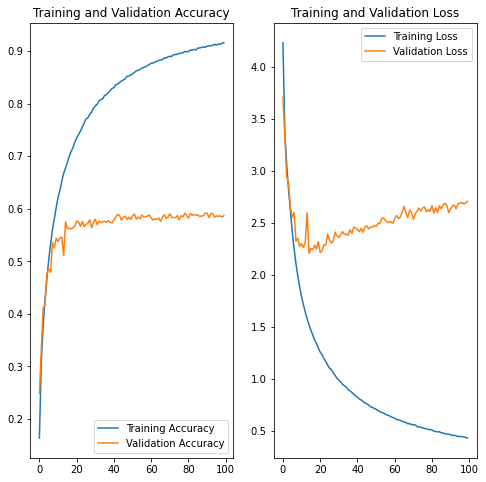

In [66]:
plotFallOffGraph(historyA)

Model A's Best Epoch

In [67]:
val_acc_per_epochA = historyA.history['val_accuracy']
best_epochA = val_acc_per_epochA.index(max(val_acc_per_epochA)) + 1
print(f'Best Epoch: {best_epochA}')

Best Epoch: 90


Model A's Train and Validation Accuracies

In [68]:
print(f'Training Accuracy: {max(historyA.history["accuracy"])}')
print(f'Validation Accuracy: {max(historyA.history["val_accuracy"])}')

Training Accuracy: 0.9162333607673645
Validation Accuracy: 0.59170001745224


Model A's Train and Validation Losses

In [69]:
print(f'Training Loss: {min(historyA.history["loss"])}')
print(f'Validation Loss: {min(historyA.history["val_loss"])}')

Training Loss: 0.4284658432006836
Validation Loss: 2.205853223800659


Saving Model A

In [70]:
modelA.load_weights('./Checkpoints/ModelA')

In [71]:
modelA.save('./Models/ModelA')

INFO:tensorflow:Assets written to: ./Models/ModelA\assets


INFO:tensorflow:Assets written to: ./Models/ModelA\assets


Clearing Session

In [72]:
tf.keras.backend.clear_session()

#### Model B ####

<p style='text-align: center'>
    <b>Best Learning Rate using Adam Optimiser: 0.001</b>
</p>

<img src='Images/ModelB_Arch.png' width='300' height='500' style='display:block; margin: auto'/>
<p style='text-align: center'>
    <b>Model B Architecture</b>
</p>

Setting up Model Checkpoint Callback

In [73]:
model_checkpoint_callbackB = tf.keras.callbacks.ModelCheckpoint(
    filepath='./Checkpoints/ModelB',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

In [74]:
best_hpsB = tunerB.get_best_hyperparameters(num_trials=1)[0]

modelB = tunerB.hypermodel.build(best_hpsB)

In [75]:
historyB = modelB.fit(trainDS, epochs=100, validation_data=valDS, callbacks=[model_checkpoint_callbackB])

Epoch 1/100
1875/1875 [==============================] - 124s 65ms/step - loss: 4.4945 - accuracy: 0.0747 - val_loss: 4.1180 - val_accuracy: 0.1134
Epoch 2/100
1875/1875 [==============================] - 122s 65ms/step - loss: 3.7988 - accuracy: 0.1631 - val_loss: 3.7930 - val_accuracy: 0.1774
Epoch 3/100
1875/1875 [==============================] - 122s 65ms/step - loss: 3.3657 - accuracy: 0.2464 - val_loss: 3.1741 - val_accuracy: 0.2870
Epoch 4/100
1875/1875 [==============================] - 122s 65ms/step - loss: 3.0793 - accuracy: 0.3078 - val_loss: 2.8253 - val_accuracy: 0.3589
Epoch 5/100
1875/1875 [==============================] - 122s 65ms/step - loss: 2.8688 - accuracy: 0.3522 - val_loss: 2.7456 - val_accuracy: 0.3870
Epoch 6/100
1875/1875 [==============================] - 122s 65ms/step - loss: 2.7039 - accuracy: 0.3897 - val_loss: 2.6049 - val_accuracy: 0.4067
Epoch 7/100
1875/1875 [==============================] - 122s 65ms/step - loss: 2.5659 - accuracy: 0.4216 - val_

Plotting Accuracy and Loss

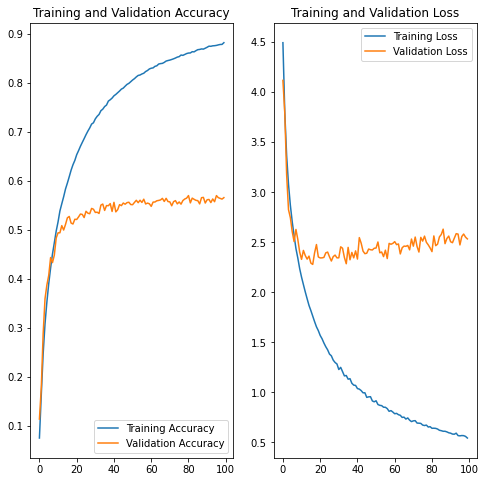

In [76]:
plotFallOffGraph(historyB)

Model B's Best Epoch

In [77]:
val_acc_per_epochB = historyB.history['val_accuracy']
best_epochB = val_acc_per_epochB.index(max(val_acc_per_epochB)) + 1
print(f'Best Epoch: {best_epochB}')

Best Epoch: 81


Model B's Train and Validation Accuracies

In [78]:
print(f'Training Accuracy: {max(historyB.history["accuracy"])}')
print(f'Validation Accuracy: {max(historyB.history["val_accuracy"])}')

Training Accuracy: 0.8813666701316833
Validation Accuracy: 0.5694000124931335


Model B's Train and Validation Losses

In [79]:
print(f'Training Loss: {min(historyB.history["loss"])}')
print(f'Validation Loss: {min(historyB.history["val_loss"])}')

Training Loss: 0.543245792388916
Validation Loss: 2.2784266471862793


Saving Model B

In [80]:
modelB.load_weights('./Checkpoints/ModelB')

In [81]:
modelB.save('./Models/ModelB')

INFO:tensorflow:Assets written to: ./Models/ModelB\assets


INFO:tensorflow:Assets written to: ./Models/ModelB\assets


Clearing Session

In [82]:
tf.keras.backend.clear_session()

# Testing Candidate Models #
Loading and Evaluating Models

In [346]:
modelA = tf.keras.models.load_model('./Models/ModelA/')

evalA = modelA.evaluate(testDS)

print(f'Loss for ModelA: {evalA[0]}')
print(f'Accuracy for ModelA: {evalA[1]}')

157/157 [==============================] - 3s 14ms/step - loss: 2.6654 - accuracy: 0.5868
Loss for ModelA: 2.665440320968628
Accuracy for ModelA: 0.5867999792098999


In [347]:
modelB = tf.keras.models.load_model('./Models/ModelB/')

evalB = modelB.evaluate(testDS)

print(f'Loss for ModelB: {evalB[0]}')
print(f'Accuracy for ModelB: {evalB[1]}')

157/157 [==============================] - 3s 19ms/step - loss: 2.3902 - accuracy: 0.5658
Loss for ModelB: 2.390237808227539
Accuracy for ModelB: 0.5658000111579895


# Fine Tuning model to original dataset #

In [475]:
modelA = tf.keras.models.load_model('./Models/ModelA/')

In [476]:
modelA.trainable = True

In [477]:
print("Number of layers in the base model: ", len(modelA.layers))

Number of layers in the base model:  27


**Please Rerun the section "Loading the Dataset" then run "Changing Data to Tensorflow datasets"  
Do not Run the section under "Load the Augmented Train Data"**

In [478]:
# Performing minor augmentations
input = layers.Input((32, 32, 3))
x = layers.RandomFlip('horizontal', seed=42)(input)
x = layers.RandomRotation(0.4, seed=42)(x)
output = layers.RandomZoom(0.4, 0.4, seed=42)(x)

dataAugmentation = keras.Model(inputs=input, outputs=output)

In [479]:
trainDS_minor = trainDS.map(lambda x, y: (dataAugmentation(x), y))

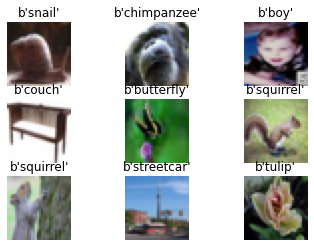

In [480]:
for image, label in trainDS_minor.take(1):
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(image[i] / 255)
        plt.title(class_names[label[i].numpy().astype('int32')])
        plt.axis('off')

plt.show()

Catastrophic forgetting happens when the model learns to generalise to the new dataset shown to it and forgets how to generalise to the data that was shown before

Therefore, fine tuning is done at layer 16 onwards and with a lower learning rate so that catastrophic forgetting doesn't happen to the model

In [481]:
fine_tune_at = 16

In [482]:
for layer in modelA.layers[:fine_tune_at]:
    layer.trainable = False

In [483]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.001/100,
    decay_steps=1875*100,
    decay_rate=5,
    staircase=False
)

New learning rate decay

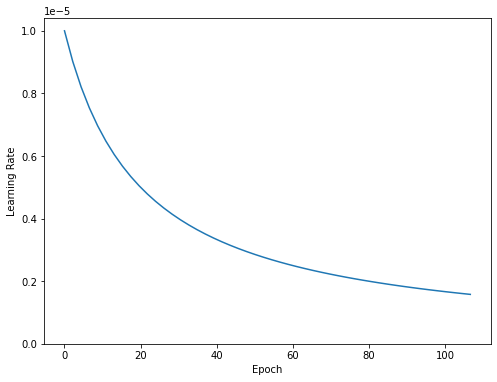

In [484]:
step = np.linspace(0, 200000)
lr = lr_schedule(step)
plt.figure(figsize=(8, 6))
plt.plot(step/1875, lr)
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')

In [485]:
modelA.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_schedule), loss=keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [486]:
modelA.summary()

Model: "Model_A"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 rescaling (Rescaling)       (None, 32, 32, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 16)        448       
                                                                 
 dropout (Dropout)           (None, 32, 32, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                           

In [487]:
len(modelA.trainable_variables)

14

In [488]:
fine_tune_epochs = 40
total_epochs =  90 + fine_tune_epochs

history_fine = modelA.fit(trainDS, epochs=total_epochs, initial_epoch=90, validation_data=valDS)

Epoch 91/130
625/625 [==============================] - 16s 23ms/step - loss: 0.3270 - accuracy: 0.9480 - val_loss: 2.4130 - val_accuracy: 0.5944
Epoch 92/130
625/625 [==============================] - 14s 23ms/step - loss: 0.3048 - accuracy: 0.9532 - val_loss: 2.4037 - val_accuracy: 0.5947
Epoch 93/130
625/625 [==============================] - 15s 24ms/step - loss: 0.2926 - accuracy: 0.9560 - val_loss: 2.3935 - val_accuracy: 0.5964
Epoch 94/130
625/625 [==============================] - 15s 24ms/step - loss: 0.2846 - accuracy: 0.9568 - val_loss: 2.3838 - val_accuracy: 0.5967
Epoch 95/130
625/625 [==============================] - 15s 24ms/step - loss: 0.2757 - accuracy: 0.9583 - val_loss: 2.3853 - val_accuracy: 0.5966
Epoch 96/130
625/625 [==============================] - 15s 24ms/step - loss: 0.2657 - accuracy: 0.9614 - val_loss: 2.3692 - val_accuracy: 0.5984
Epoch 97/130
625/625 [==============================] - 15s 24ms/step - loss: 0.2589 - accuracy: 0.9621 - val_loss: 2.3693 -

In [489]:
evalA = modelA.evaluate(testDS)

print(f'Loss for ModelA: {evalA[0]}')
print(f'Accuracy for ModelA: {evalA[1]}')

157/157 [==============================] - 2s 14ms/step - loss: 2.3446 - accuracy: 0.6005
Loss for ModelA: 2.3445851802825928
Accuracy for ModelA: 0.6004999876022339


In [490]:
modelA.save('./Models/ModelA')

INFO:tensorflow:Assets written to: ./Models/ModelA\assets


INFO:tensorflow:Assets written to: ./Models/ModelA\assets


# The Final Model #

In [500]:
modelA = tf.keras.models.load_model('./Models/ModelA/')

# Model Understanding #

## Implementing Integrated Gradients ##
Uses  
-   Helps develop intuition for how and why it works
-   If features highlighted does not match intuition, it may mean that there is a bug in the model or dataset or may be indicative of overfitting

Limitations  
-   Only provides feature importance on individual examples and therefore does not provide global feature importance across datasets  
-   Only provides individual feature importance and therefore does not explain feature interactions and combinations

### Establishing a baseline image ###

Just going to be a black 28 * 28 * 1 image for now so that it will be the same as the input image

In [567]:
baseline = tf.zeros(shape=(32, 32, 3))

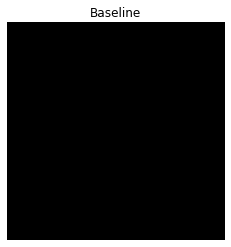

In [568]:
plt.imshow(baseline, cmap='gray')
plt.title("Baseline")
plt.axis('off')
plt.show()

### Interpolate Images ###

In [569]:
def interpolate_images(baseline,image,alphas):
    alphas_x = alphas[:, tf.newaxis, tf.newaxis, tf.newaxis]
    baseline_x = tf.expand_dims(baseline, axis=0)
    input_x = tf.expand_dims(image, axis=0)
    delta = input_x - baseline_x
    images = baseline_x +  alphas_x * delta
    return images

### Compute Gradients ###

In [570]:
def compute_gradients(images, target_class_idx):
  with tf.GradientTape() as tape:
    tape.watch(images)
    probs = modelA(images)
    
  return tape.gradient(probs, images)

### Integral Approximation ###

In [571]:
def integral_approximation(gradients):
  # riemann_trapezoidal
  grads = (gradients[:-1] + gradients[1:]) / tf.constant(2.0)
  integrated_gradients = tf.math.reduce_mean(grads, axis=0)
  
  return integrated_gradients

### Putting it all together ###

Combines the 3 previous parts together into a function called Integrated Gradients and will use a @tf.function decorator to compile it into a high performance TensorFlow graph  

$$
IntegratedGrads^{approx}_{i}(x)::=\overbrace{(x_{i}-x'_{i})}^\text{5.}\times \overbrace{\sum_{k=1}^{m} }^\text{4.} \frac{\partial \overbrace{F(\overbrace{x' + \overbrace{\frac{k}{m} }^\text{1.}\times(x - x'))}^\text{2.} }^\text{3.} }{\partial x_{i} } \times \overbrace{\frac{1}{m} }^\text{4.}
$$

#### Steps ####
1. Generate alphas
2. Generate interpolated images = $(x' + \frac{k}{m}\times(x - x'))$
3. Compute gradients between model $F$ output predictions with respect to input features = $\frac{\partial F(\text{interpolated path inputs})}{\partial x_{i} }$
4. Integral approximation through averaging gradients = $\sum_{k=1}^m \text{gradients} \times \frac{1}{m}$
5. Scale integrated gradients with respect to original image = $(x_{i}-x'_{i}) \times \text{integrated gradients}$. The reason this step is necessary is to make sure that the attribution values accumulated across multiple interpolated images are in the same units and faithfully represent the pixel importances on the original image.

In [572]:
@tf.function
def one_batch(baseline, image, alpha_batch, target_class_idx):
    # Generate interpolated inputs between baseline and input.
    interpolated_path_input_batch = interpolate_images(baseline=baseline, image=image, alphas=alpha_batch)

    # Compute gradients between model outputs and interpolated inputs.
    gradient_batch = compute_gradients(images=interpolated_path_input_batch, target_class_idx=target_class_idx)
    
    return gradient_batch

In [573]:
def integrated_gradients(baseline, image, target_class_idx, m_steps=50, batch_size=32):
  # Generate alphas.
  alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1)

  # Collect gradients.    
  gradient_batches = []

  # Iterate alphas range and batch computation for speed, memory efficiency, and scaling to larger m_steps.
  for alpha in tf.range(0, len(alphas), batch_size):
    from_ = alpha
    to = tf.minimum(from_ + batch_size, len(alphas))
    alpha_batch = alphas[from_:to]

    gradient_batch = one_batch(baseline, image, alpha_batch, target_class_idx)
    gradient_batches.append(gradient_batch)

  # Concatenate path gradients together row-wise into single tensor.
  total_gradients = tf.concat(gradient_batches, axis=0)

  # Integral approximation through averaging gradients.
  avg_gradients = integral_approximation(gradients=total_gradients)

  # Scale integrated gradients with respect to input.
  integrated_gradients = (image - baseline) * avg_gradients

  return integrated_gradients

In [592]:
def plot_img_attributions(baseline,
                          image,
                          target_class_idx,
                          m_steps=50,
                          cmap=None,
                          overlay_alpha=0.4):

  attributions = integrated_gradients(baseline=baseline,
                                      image=image,
                                      target_class_idx=target_class_idx,
                                      m_steps=m_steps)

  # Sum of the attributions across color channels for visualization.
  # The attribution mask shape is a grayscale image with height and width
  # equal to the original image.
  attribution_mask = tf.reduce_sum(tf.math.abs(attributions), axis=-1)

  fig, axs = plt.subplots(nrows=2, ncols=2, squeeze=False, figsize=(8, 8))

  axs[0, 0].set_title('Baseline image')
  axs[0, 0].imshow(baseline)
  axs[0, 0].axis('off')

  axs[0, 1].set_title('Original image')
  axs[0, 1].imshow(image / 255)
  axs[0, 1].axis('off')

  axs[1, 0].set_title('Attribution mask')
  axs[1, 0].imshow(attribution_mask, cmap=cmap)
  axs[1, 0].axis('off')

  axs[1, 1].set_title('Overlay')
  axs[1, 1].imshow(attribution_mask, cmap=cmap)
  axs[1, 1].imshow(image / 255, alpha=overlay_alpha)
  axs[1, 1].axis('off')

  plt.tight_layout()
  return fig

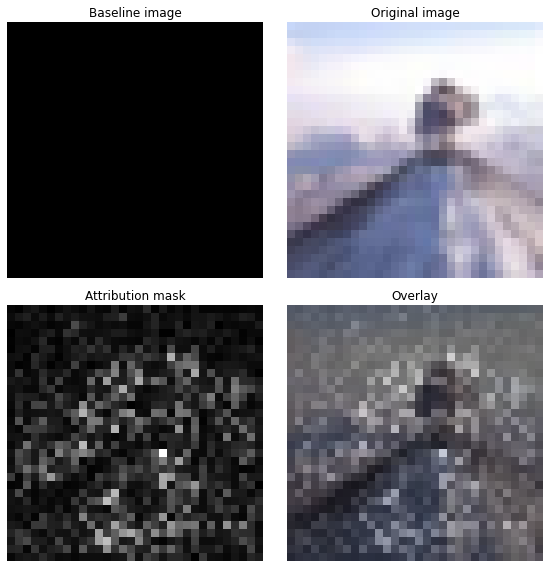

In [593]:
_ = plot_img_attributions(image=X_test[0].astype('float32'), baseline=baseline, target_class_idx=y_test[0], m_steps=240, cmap='gray', overlay_alpha=0.4)

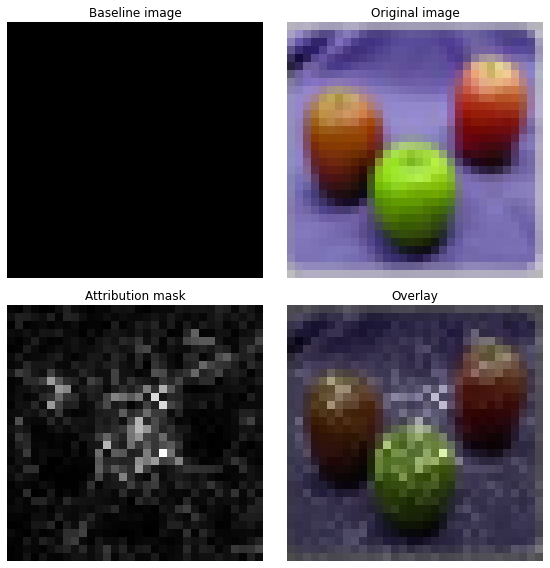

In [594]:
_ = plot_img_attributions(image=X_test[9].astype('float32'), baseline=baseline, target_class_idx=y_test[9], m_steps=240, cmap='gray', overlay_alpha=0.4)

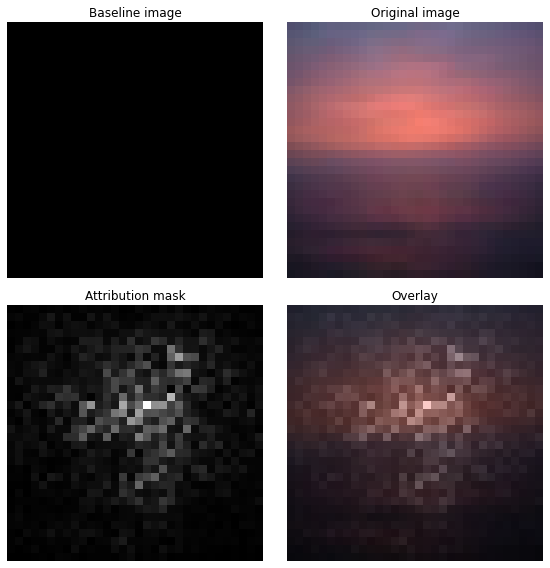

In [595]:
_ = plot_img_attributions(image=X_test[4].astype('float32'), baseline=baseline, target_class_idx=y_test[4], m_steps=240, cmap='gray', overlay_alpha=0.4)

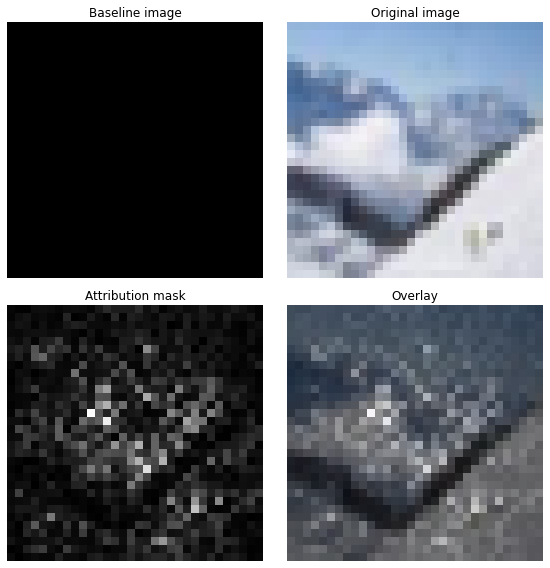

In [596]:
_ = plot_img_attributions(image=X_test[42].astype('float32'), baseline=baseline, target_class_idx=y_test[4], m_steps=240, cmap='gray', overlay_alpha=0.4)

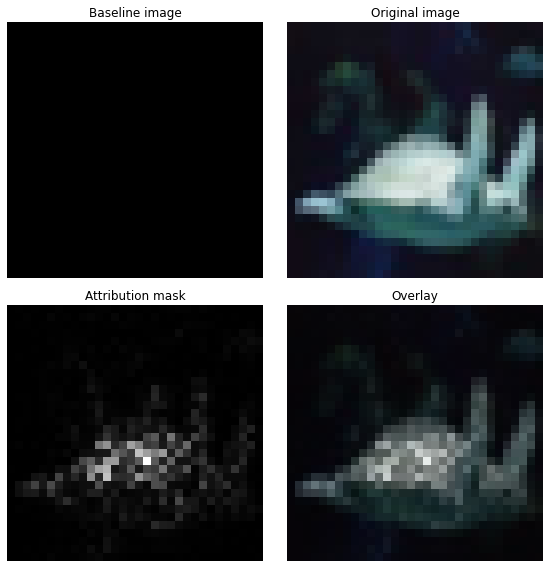

In [597]:
_ = plot_img_attributions(image=X_test[33].astype('float32'), baseline=baseline, target_class_idx=y_test[4], m_steps=240, cmap='gray', overlay_alpha=0.4)

By using integrated gradients, it can be seen that the model has a reason why and how it predicts its outputs, which is that if the image is an object, it will focus on the objects, but with landscape images, it will look at the entire image but pays attention to the important features of the terrain

# Looking at CIFAR20 #

## Loading the Dataset with superclass Labels ##

In [5]:
X_train = unpickle('./Data/cifar-100-python/train')[b'data']
y_train = np.array(unpickle('./Data/cifar-100-python/train')[b'coarse_labels'])

X_test = unpickle('./Data/cifar-100-python/test')[b'data']
y_test = np.array(unpickle('./Data/cifar-100-python/test')[b'coarse_labels'])

class_names = np.array(unpickle('./Data/cifar-100-python/meta')[b'coarse_label_names'])

In [6]:
X_train = np.apply_along_axis(lambda x: x.reshape(3, 32, 32).transpose(1, 2, 0), 1, X_train)

X_test = np.apply_along_axis(lambda x: x.reshape(3, 32, 32).transpose(1, 2, 0), 1, X_test)

In [7]:
X_val = X_train[-10000:]
y_val = y_train[-10000:]

X_train = X_train[:-10000]
y_train = y_train[:-10000]

In [8]:
cifar100_numClasses = len(class_names)

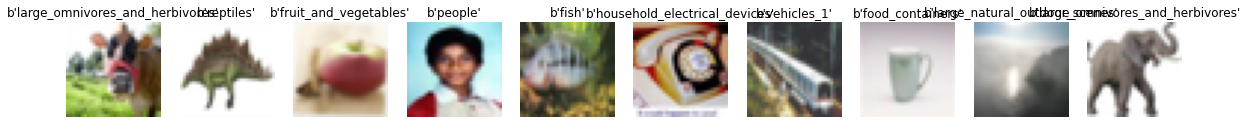

In [9]:
plt.figure(figsize=(20, 20))

for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(X_train[i])
    plt.title(class_names[y_train[i]])
    plt.axis('off')
    
plt.show()

In [10]:
trainDS = tf.data.Dataset.from_tensor_slices((X_train, y_train))

valDS = tf.data.Dataset.from_tensor_slices((X_val, y_val))
testDS = tf.data.Dataset.from_tensor_slices((X_test, y_test))

Batching the Validation and Test datasets

In [11]:
BATCH_SIZE=64
SHUFFLE_BUFFER_SIZE = 2000

trainDS = trainDS.shuffle(SHUFFLE_BUFFER_SIZE, seed=42).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
valDS = valDS.batch(BATCH_SIZE)
testDS = testDS.batch(BATCH_SIZE)

## Building Best model for CIFAR100 ##

In [12]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.001,
    decay_steps=1875*100,
    decay_rate=5,
    staircase=False
)

In [15]:
input = layers.Input((32, 32, 3))
x = layers.Rescaling(1/255)(input)

x = layers.Conv2D(16, 3, padding='same', activation='swish')(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(32, 3, padding='same', activation='swish')(x)
x = layers.BatchNormalization()(x)

x = layers.Conv2D(64, 3, padding='same', activation='swish')(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(128, 3, padding='same', activation='swish')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPool2D()(x)

x = layers.Conv2D(256, 3, padding='same', activation='swish')(x)
x = layers.BatchNormalization()(x)

x = layers.Conv2D(128, 3, padding='same', activation='swish')(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(128, 3, padding='same', activation='swish')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPool2D()(x)

x = layers.Conv2D(256, 3, padding='same', activation='swish')(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(256, 3, padding='same')(x)
x = layers.BatchNormalization()(x)

x = layers.Dropout(0.3)(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='swish', kernel_regularizer=keras.regularizers.l2(0.01))(x)
x = layers.BatchNormalization()(x)

output = layers.Dense(cifar100_numClasses, activation='softmax')(x)

model = keras.Model(inputs=input, outputs=output, name='Model_A')
    
model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_schedule), loss=keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

## Training Model ##

In [17]:
history = model.fit(trainDS, epochs=100, validation_data=valDS)

Epoch 1/100
625/625 [==============================] - 53s 43ms/step - loss: 3.2364 - accuracy: 0.2418 - val_loss: 2.9453 - val_accuracy: 0.2245
Epoch 2/100
625/625 [==============================] - 26s 42ms/step - loss: 2.5744 - accuracy: 0.3431 - val_loss: 2.7473 - val_accuracy: 0.3541
Epoch 3/100
625/625 [==============================] - 26s 42ms/step - loss: 2.3307 - accuracy: 0.4165 - val_loss: 2.3197 - val_accuracy: 0.4241
Epoch 4/100
625/625 [==============================] - 27s 43ms/step - loss: 2.1032 - accuracy: 0.4803 - val_loss: 2.2360 - val_accuracy: 0.4444
Epoch 5/100
625/625 [==============================] - 27s 43ms/step - loss: 1.9391 - accuracy: 0.5283 - val_loss: 2.1120 - val_accuracy: 0.4921
Epoch 6/100
625/625 [==============================] - 27s 43ms/step - loss: 1.8161 - accuracy: 0.5601 - val_loss: 2.0404 - val_accuracy: 0.5000
Epoch 7/100
625/625 [==============================] - 27s 44ms/step - loss: 1.7138 - accuracy: 0.5925 - val_loss: 1.9532 - val_ac

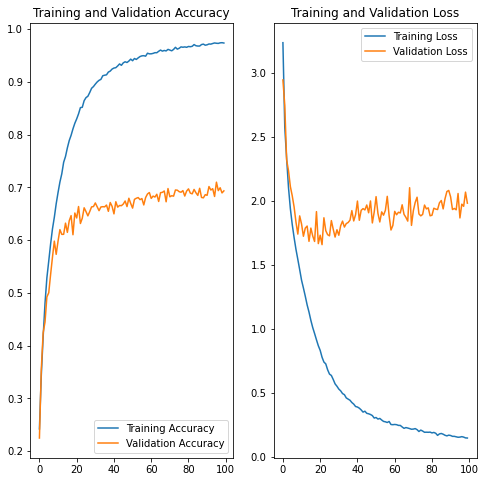

In [18]:
plotFallOffGraph(history)

Model's Best Epoch

In [19]:
val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print(f'Best Epoch: {best_epoch}')

Best Epoch: 96


Model's Train and Validation Accuracies

In [20]:
print(f'Training Accuracy: {max(history.history["accuracy"])}')
print(f'Validation Accuracy: {max(history.history["val_accuracy"])}')

Training Accuracy: 0.9743750095367432
Validation Accuracy: 0.7098000049591064


Model's Train and Validation Losses

In [21]:
print(f'Training Loss: {min(history.history["loss"])}')
print(f'Validation Loss: {min(history.history["val_loss"])}')

Training Loss: 0.1469382792711258
Validation Loss: 1.6581488847732544


## Evualuating Model ##

In [22]:
evaluation = model.evaluate(testDS)

print(f'Loss for ModelA: {evaluation[0]}')
print(f'Accuracy for ModelA: {evaluation[1]}')

157/157 [==============================] - 2s 14ms/step - loss: 2.0206 - accuracy: 0.6906
Loss for ModelA: 2.0206298828125
Accuracy for ModelA: 0.6905999779701233
